**Problem Statement**

The objective is to provide an effective and robust approach to detect and classify defects on material surface using computer vision and machine learning, thereby comparing various metrics to decide with algorithm works best.
  
The input is taken from the DAGM challenge, which is available online. This database contains six classes of defects each containing 1000 non-defective images and 150 defective images for each class.

This solution can even be used in real-time applications.

**Importing required packages**

In [0]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

**Handling Dataset**

Dataset link : https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html


The provided data is artificially generated, but similar to real world problems. It consists of multiple data sets, each consisting of 1000 images showing the background texture without defects, and of 150 images with one labeled defect each on the background texture. The images in a single data set are very similar, but each data set is generated by a different texture model and defect model. 

Collab notebook keeps on crashing because of memory issues, to handle this we have reduced image size to 256 by 256 and selected only 1200 of 6000 non defective images available(200 from each class). Given an image the objective is to determine if its defective or not, and if it is defective then determine which class of defect it corresponds to.

In [0]:
#Mounting drive to access dataset  
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# This method to reduce 512 by 512 images to 256 by 256

def compress_image(original_image):
  size = (256, 256)
  fit_and_resized_image = ImageOps.fit(original_image, size, Image.ANTIALIAS)

  return np.array(fit_and_resized_image.getdata()).reshape(256,256)

In [0]:
from PIL import Image, ImageOps

input_X=[]
output_Y = []

for i in range(1,7):
    #fetching data
    
    INPUT_SCAN_FOLDER='/content/drive/My Drive/Class'+str(i) # path where the dataset is stored
    
    for dirName, subdirList, fileList in os.walk(INPUT_SCAN_FOLDER):
        count = 0    
        for filename in fileList:
            if(count >= 200):
                break
            count+=1
            if ".png" in filename.lower():
                    input_X.append(compress_image(Image.open(os.path.join(dirName, filename))))
                    output_Y.extend([0])
                    #print(len(input_X))
    print(i)
    INPUT_SCAN_FOLDER='/content/drive/My Drive/Class'+str(i)+'_def' # path where the dataset is stored
    
    for dirName, subdirList, fileList in os.walk(INPUT_SCAN_FOLDER):
            for filename in fileList:
                if ".png" in filename.lower():
                    input_X.append(compress_image(Image.open(os.path.join(dirName, filename))))
                    output_Y.extend([i])


1
2
3
4
5
6


In [0]:
print(len(input_X))

2103


**Extracting features from Dataset:**

No preprocessing is used on the input images, as the defects of the steel plate heavily depend on the texture of its surface and, as we are using textural features, any preprocessing method such as smoothing or sharpening will change its texture.

Features used in ML classification are: contrast, dissimilarity, homogeneity, energy, and asymmetry.
More about these features can be found [here](https://support.echoview.com/WebHelp/Windows_and_Dialog_Boxes/Dialog_Boxes/Variable_properties_dialog_box/Operator_pages/GLCM_Texture_Features.htm)


In [0]:
from skimage.feature import greycomatrix,greycoprops
import pandas as pd


proList = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy']
featlist= ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy','Label']
properties =np.zeros(5)
glcmMatrix = []
final=[]


for i in range(len(input_X)):
    img = input_X[i]

    # pyplot.imshow((images[k,:,:]),cmap='gray')
    # pyplot.show()
    #  get properties
    glcmMatrix=(greycomatrix(img, [1], [0], levels=256))

   # print(len(glcmMatrix))
    # get properties
    for j in range(0, len(proList)):
        properties[j]=(greycoprops(glcmMatrix, prop=proList[j]))

    features = np.array([properties[0],properties[1],properties[2],properties[3],properties[4],output_Y[i]])
    #print(features)
    final.append(features)

df = pd.DataFrame(final,columns=featlist)
df.to_excel('/content/drive/My Drive/features.xlsx')


In [0]:
df.to_excel('features.xlsx')

The data is split into 80% training and 20% testing in this block. These variables will be used for all machine learning models.


In [0]:
X=np.array((df.as_matrix()))
Y=X[:,5]
X=X[:,0:5]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=10)
y_train = y_train.astype('int')
y_test = y_test.astype('int')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


**K- nearest neighbours:**

K-Nearest Neighbors, KNN for short, is a supervised learning algorithm specialized in classification. It is a simple algorithm that stores all available cases and classifies new cases by a majority vote of its k neighbors. The case being assigned to the class is the most common among its K nearest neighbors measured by a distance function.

K is the only parameter in this algorithm. K is usually odd so that one class gets higher majority.

In [0]:
# KNN
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

K_value = 10
neigh = KNeighborsClassifier(n_neighbors=K_value, weights='uniform', algorithm='auto')
neigh.fit(X_train, y_train)
testt=neigh.predict(X_test)
scoree=accuracy_score(y_test, testt)
print("KNN testing accuracy=",scoree*100)


KNN testing accuracy= 53.681710213776725


**SVM:**

In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes very well. 


In [0]:
#SVM
from sklearn.svm import SVC 

svmclassifier = SVC(kernel='linear')  
svmclassifier.fit(X_train, y_train)  
svm_y_pred = svmclassifier.predict(X_test)
svm_score = accuracy_score(y_test, svm_y_pred)
print("SVM testing accuracy=",svm_score*100)


NameError: ignored

**Decision Tree**

A decision tree is a flowchart-like structure in which each internal node represents a “test” on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

In [0]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps

for i in range(15,21):
    Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=i)
    Tree_model.fit(X_train, y_train)
    tree_pred = Tree_model.predict(X_test)
    tree_score = accuracy_score(y_test, tree_pred)
    print("Decision testing accuracy (depth=",i,")=",tree_score*100)

#print(Tree_model.predict_proba(np.array([X])))


Decision testing accuracy (depth= 15 )= 61.282660332541575
Decision testing accuracy (depth= 16 )= 59.61995249406176
Decision testing accuracy (depth= 17 )= 60.33254156769596
Decision testing accuracy (depth= 18 )= 60.09501187648456
Decision testing accuracy (depth= 19 )= 60.57007125890736
Decision testing accuracy (depth= 20 )= 60.09501187648456


**Random forest regression:**

The Random Forest is one of the most effective machine learning models for predictive analytics. The random forest model is a type of additive model that makes predictions by combining decisions from a sequence of base models(decision trees).

Random forest is nothing but an ensemble of decision trees. It avoids the problem of over-fitting that is usually seen in decision trees where there is a single decision tree for the entire dataset.

In [0]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=500, max_depth = 15 ,random_state=70)  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred_round = [round(x) for x in y_pred]

y_score = accuracy_score(y_test, y_pred_round)
print("Random forest testing accuracy=",y_score*100)


Random forest testing accuracy= 33.729216152019006


In [0]:
# Gradient boosting
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 5,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
GD_score = accuracy_score(y_test, [round(x) for x in clf.predict(X_test)])
print("Gradient Boosting testing accuracy=",GD_score*100)


Gradient Boosting testing accuracy= 46.79334916864608


**Preparing data for CNN:**

Unlike machine learning concepts there is no need to extract parameters explicitly, CNNs take pixcel values of images and extract features for classification themselves. 



In [0]:
output_Y = np.array(output_Y)
output_Y = output_Y.reshape(len(output_Y),1)
output_Y = np_utils.to_categorical(output_Y)


input_X = np.array(input_X)
input_X = input_X.reshape(len(input_X),256,256,1)
print(input_X.shape)
input_X = np.append(input_X,np.zeros(shape=input_X.shape),axis = 3)
input_X = np.append(input_X,np.zeros(shape=(2103,256,256,1)),axis = 3)
#input_X = np.repeat(input_X[..., np.newaxis], 3, -1)
input_X = input_X/255

X_train, X_test, y_train, y_test = train_test_split(input_X , output_Y, test_size=0.1, random_state=42)

input_X.shape

(2103, 256, 256, 1)


(2103, 256, 256, 3)

In [0]:
from keras.layers import Dropout,AveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


#parameters for architecture
input_shape = (256, 256, 3)
num_classes = 7
conv_size = 32

# parameters for training
batch_size = 32
num_epochs = 20
# build the model
model = Sequential()

model.add(Conv2D(conv_size, (5, 5), activation='relu', padding='same', input_shape=input_shape)) 
model.add(AveragePooling2D(pool_size=(4, 4)))

model.add(Conv2D(conv_size, (5, 5), activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size=(4, 4)))
    
#model.add(Conv2D(conv_size, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Flatten())

model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
 

# train the model                    
history1 = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
validation_split=0.1)

out = model.predict(X_test)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 256, 256, 32)      2432      
_________________________________________________________________
average_pooling2d_10 (Averag (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 64, 64, 32)        25632     
_________________________________________________________________
average_pooling2d_11 (Averag (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
__________

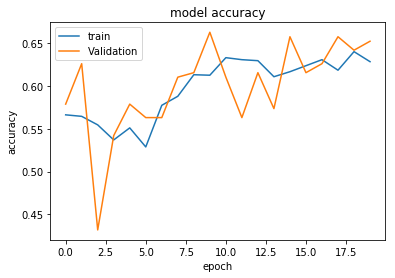

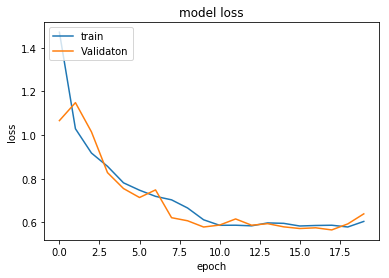

In [0]:
import matplotlib.pyplot as plt


plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validaton'], loc='upper left')
plt.show()

In [0]:
cc = 0
for i in out:
  if(sum(i)== 2):
    cc+=1
print(cc)
print(len(out))

0
211


In [0]:
ccc = 0
for i in output_Y:
  if(i[0]==1):
    ccc+=1
print(ccc)

903


In [1]:
from keras.utils import np_utils
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import load_model


# parameters for architecture
input_shape = (256, 256, 3)
num_classes = 7
conv_size = 32

# parameters for training
batch_size = 32
num_epochs = 1

# load InceptionV3 from Keras
InceptionV3_model = InceptionV3(include_top=False, input_shape=input_shape)

# add custom Layers     
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
Custom_Output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
model = Model(inputs = InceptionV3_model.input, outputs = Custom_Output)
        
# compile the model
model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

#model.summary()

# train the model 
history2 = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
validation_split=0.1)

out = model.predict(X_test)
model.save('inception_model0.h5')

print('250 done')

for i in range(1,8):
    model = load_model('inception_model'+str(i-1)+'.h5')

    model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        verbose=1,
    validation_split=0.1)

    model.save('inception_model'+str(i)+'.h5')
    
    print(str(250*(i+1))+' done')

ModuleNotFoundError: No module named 'keras'

In [0]:

# parameters for architecture
input_shape = (256, 256, 3)
num_classes = 7
conv_size = 32

# parameters for training
batch_size = 32
num_epochs = 20

# load InceptionV3 from Keras
InceptionV3_model = InceptionV3(include_top=False, input_shape=input_shape)

# add custom Layers     
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
Custom_Output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
model = Model(inputs = InceptionV3_model.input, outputs = Custom_Output)
        
# compile the model
model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

#model.summary()

# train the model 
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
validation_split=0.1)

out = model.predict(X_test)
model.save('my_model.h5')




Train on 1702 samples, validate on 190 samples
Epoch 1/20
1702/1702 [==============================] - 48s 28ms/step - loss: 0.9775 - acc: 0.5470 - val_loss: 4.7854 - val_acc: 0.2316
Epoch 2/20
1702/1702 [==============================] - 22s 13ms/step - loss: 0.7382 - acc: 0.5846 - val_loss: 2.7548 - val_acc: 0.6421
Epoch 3/20
1702/1702 [==============================] - 22s 13ms/step - loss: 0.7029 - acc: 0.6040 - val_loss: 2.7976 - val_acc: 0.5368
Epoch 4/20
1702/1702 [==============================] - 22s 13ms/step - loss: 0.6724 - acc: 0.6169 - val_loss: 1.6679 - val_acc: 0.5947
Epoch 5/20
1702/1702 [==============================] - 22s 13ms/step - loss: 0.6340 - acc: 0.6058 - val_loss: 1.9972 - val_acc: 0.5105
Epoch 6/20
1702/1702 [==============================] - 22s 13ms/step - loss: 0.6113 - acc: 0.6475 - val_loss: 1.8310 - val_acc: 0.6368
Epoch 7/20
1702/1702 [==============================] - 22s 13ms/step - loss: 0.7302 - acc: 0.6345 - val_loss: 4.5494 - val_acc: 0.5158
E

In [0]:
from keras.models import load_model

model = load_model('my_model.h5')

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
validation_split=0.1)


Train on 1702 samples, validate on 190 samples
Epoch 1/20
1702/1702 [==============================] - 33s 19ms/step - loss: 0.4082 - acc: 0.7720 - val_loss: 0.3544 - val_acc: 0.8053
Epoch 2/20
1056/1702 [=================>............] - ETA: 7s - loss: 0.4174 - acc: 0.7670

KeyboardInterrupt: ignored

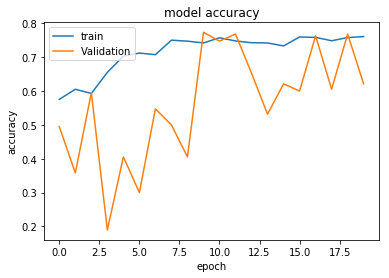

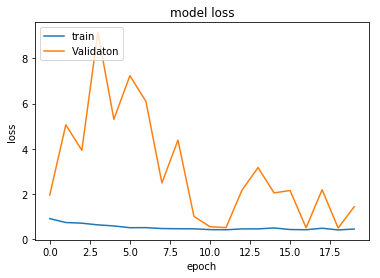

In [0]:
import matplotlib.pyplot as plt


plt.plot(history.history1['acc'])
plt.plot(history.history2['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['SimpleCNN', 'Inception'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history1['val_acc'])
plt.plot(history.history2['val_acc'])
plt.title('model loss')
plt.ylabel('accracy')
plt.xlabel('epoch')
plt.legend(['SimpleCNN', 'Inception'], loc='upper left')
plt.show()